In [10]:
import pandas as pd
import numpy as np
import sys, os
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from MetaIPM import network
from MetaIPM import populated_network
from MetaIPM import stochastic_wrapper as sw
from MetaIPM import summarize_outputs as so
from MetaIPM import recruitment
data_file_path = "./ModelData/"
import matplotlib as mpl
import cycler

graphics = "./Graphics/"

In [11]:
network_file = "network.csv"
transition_probs = "psi2.csv"
transition_key = "psi_key2.csv"
node_file = "node.csv"
group_file = "group_details.csv"
lw_file = "LW_Pool.csv"
vonB_file = "vonB.csv"
vonB_sigma_file = "vonB_sigma.csv"
maturity_file = "maturity.csv"

In [12]:
network_data = pd.read_csv(data_file_path + network_file)
transition_data = pd.read_csv(data_file_path  + transition_probs)
transition_key_data = pd.read_csv(data_file_path  + transition_key)
node_data = pd.read_csv(data_file_path + node_file)
group_data = pd.read_csv(data_file_path + group_file)
lw_data = pd.read_csv(data_file_path + lw_file)
vonB_data = pd.read_csv(data_file_path + vonB_file)
vonB_sigma_data = pd.read_csv(data_file_path + vonB_sigma_file)
maturity_data = pd.read_csv(data_file_path + maturity_file)

In [13]:
def make_model():
    '''
    Creates a model using the global parameter dataframes.
    
    Returns:
    (populated_network): A network representing the model described in the global parameter dataframes
    '''
    deterministic_model = populated_network.populate_network_from_csv(
        network_data = network_data,
        transition_data = transition_data,
        transition_key_data = transition_key_data,
        node_data = node_data,
        group_data = group_data,
        lw_data = lw_data,
        vonB_data = vonB_data,
        vonB_sigma_data = vonB_sigma_data,
        maturity_data = maturity_data,
        stochastic_spawn = False,
        stochastic_pars = False
        ).show_network()
    return deterministic_model

In [14]:
def extract_population(model):
    '''
    Extracts the populations counts for each year and node from a model
    
    Parameters:
    model (populated_network): Network to extract population counts from
    
    Returns:
    (DataFrame): Table containing year, population, and node.
    '''
    out_all = so.extract_all_populations(model)
    out_all = out_all[out_all["Year"] < out_all["Year"].max()]

    out_by_node = out_all.groupby(['Year','Month','Node'])[['Population']].sum().reset_index()
    out_by_node["Months"] = out_by_node["Month"] + out_by_node["Year"]
    out_by_node = out_by_node[out_by_node["Month"] == 0]
    out_by_node['Years'] = out_by_node['Months']
    
    return out_by_node[['Years', 'Population', 'Node']]

In [15]:
def run_with_parameter(frame, col, row, value):
    '''
    Creates and runs a model with a modified parameter values.

    Parameters:
    frame (DataFrame): The dataframe where the parameter is stored.
    col (str):         The column containing the parameter.
    row (int):         The row containing the parameter.
    value (int):       The value to assign to the parameter.
    
    Returns:
    (DataFrame): A dataframe where each row represents the population distribution for each group in each population for every year.
    '''
    
    init = frame.loc[row, col]
    frame.loc[row, col] = value
    model = make_model()
    model.project_network()
    frame.loc[row, col] = init
    
    return extract_population(model)

In [16]:
def calculate_sensitivity(frame, col, row, value, delta):
    '''
    Calculates the sensitivity of a parameter at the specified value 
    for each year the model is run.
    Sensitivity is defined as the derivative of the growth rate with
    respect to the parameter. The derivative is calculated 
    using the central differenences method.
    
    Parameters:
    frame (DataFrame): The dataframe where the parameter is stored.
    col (str):         The column containing the parameter.
    row (int):         The row containing the parameter.
    value (int):       The value to assign to the parameter.
    delta (float):     Percent change to be used when calculating sensitivity.
    
    Returns:
    (int): The sensitivity of the specified parameter at the specified value.
    '''
    
    # Calculate with lower parameter
    ## Run model with lower parameter
    lower = run_with_parameter(frame, col, row, value*(1-delta))
    ## Calculate total yearly population for each pool
    l_a = (lower[lower['Node'] == 'a'])['Population']
    l_a = l_a[1:].values / l_a[:-1].values
    l_b = (lower[lower['Node'] == 'b'])['Population']
    l_b = l_b[1:].values / l_b[:-1].values
    l_c = (lower[lower['Node'] == 'c'])['Population']
    l_c = l_c[1:].values / l_c[:-1].values

    no_change = run_with_parameter(frame, col, row, value)
    ## Calculate total yearly population for each pool
    n_a = (no_change[no_change['Node'] == 'a'])['Population']
    n_a = n_a[1:].values / n_a[:-1].values
    n_b = (no_change[no_change['Node'] == 'b'])['Population']
    n_b = n_b[1:].values / n_b[:-1].values
    n_c = (no_change[no_change['Node'] == 'c'])['Population']
    n_c = n_c[1:].values / n_c[:-1].values
    
    # Calculate with upper parameter
    ## Run model with upper parameter
    upper = run_with_parameter(frame, col, row, value*(1+delta))
    u_a = (upper[upper['Node'] == 'a'])['Population']
    u_a = u_a[1:].values / u_a[:-1].values
    u_b = (upper[upper['Node'] == 'b'])['Population']
    u_b = u_b[1:].values / u_b[:-1].values 
    u_c = (upper[upper['Node'] == 'c'])['Population']
    u_c = u_c[1:].values / u_c[:-1].values 
    
    # Calculate sensitivities
    S_a = (u_a - l_a)/(2*delta*value)
    S_b = (u_b - l_b)/(2*delta*value)
    S_c = (u_c - l_c)/(2*delta*value)
    
    return S_a, S_b, S_c, l_a, l_b, l_c, n_a, n_b, n_c, u_a, u_b, u_c

In [17]:
def calculate_sensitivities(frame, col, row, values, delta):
    sens_a = []
    sens_b = []
    sens_c = []
    for value in values:
        S_a, S_b, S_c, _, _, _, _, _, _, _, _, _ = calculate_sensitivity(frame, col, row, value, delta)
        sens_a.append(S_a)
        sens_b.append(S_b)
        sens_c.append(S_c)
    return sens_a, sens_b, sens_c

In [23]:
def graph_results(sens_a, sens_b, sens_c, param, values, start_at=0, filename=None):
    # Set up colormap
    n = len(sens_a)
    color = plt.cm.viridis(np.linspace(0.1,0.9,n)) # This returns RGBA; convert:
    mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)
    plt.style.use('seaborn-whitegrid')
    
    # Set up subplots
    fig, axs = plt.subplots(1, 3, sharey=True,
                           subplot_kw={'box_aspect':1},
                           gridspec_kw={'wspace':0.05})
    
    
    # Plot nodes
    
    ## Starved Rock
    plt.sca(axs[0])
    for i in range(len(sens_c)):
        S_c = sens_c[i]
        plt.plot(range(start_at, len(S_c)), S_c[start_at:], label=values[i])
    plt.title('Starved Rock', fontsize=15)
    plt.xlabel('Years', fontsize=15)
    plt.ylabel(r'Sensitivity of $\lambda$', fontsize=15)
    
    ## Marseilles
    plt.sca(axs[1])
    for S_b in sens_b:
        plt.plot(range(start_at, len(S_b)), S_b[start_at:])
    plt.title('Marseilles', fontsize=15)
    plt.xlabel('Years', fontsize=15)
    axs[1].label_outer()

    ## Dresden Island
    plt.sca(axs[2])
    for i in range(len(sens_a)):
        S_a = sens_a[i]
        plt.plot(range(start_at, len(S_a)), S_a[start_at:])
    plt.title('Dresden Island', fontsize=15)
    plt.xlabel('Years', fontsize=15)
    plt.ylabel(r'Sensitivity of $\lambda$', fontsize=15)
    
    plt.subplots_adjust(top=1, right=0.8)
    fig.legend(frameon=True, loc='center right', title=param)
    if filename != None:
        plt.savefig(f'{graphics}/{filename}.svg', bbox_inches='tight')
    
    plt.show()

## $L_{\infty L}$

C:\Users\Cameron\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.7.egg\MetaIPM\network.py:173: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
C:\Users\Cameron\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.7.egg\MetaIPM\node.py:104: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


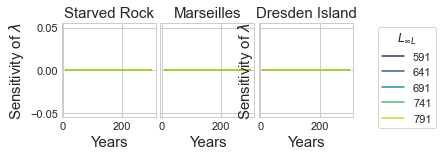

In [24]:
values = [591, 641, 691, 741, 791]
table = vonB_data
col = 'V1'
row = 0
name = r'$L_{\infty L}$'

sens_a, sens_b, sens_c = calculate_sensitivities(table, col, row, values, .01)
graph_results(sens_a, sens_b, sens_c, name, values, start_at=10, filename='l_inf_sensitivity')

## $K_G$

In [ ]:
values = [0.656, 0.706, 0.756, 0.806, 0.856]
table = vonB_data
col = 'V1'
row = 1
name = r'$K_G$'

sens_a, sens_b, sens_c = calculate_sensitivities(table, col, row, values, .01)
graph_results(sens_a, sens_b, sens_c, name, values, start_at=10, filename='k_sensitivity')

## $\sigma_G$

In [ ]:
values = [20, 40, 60, 80, 100]
table = vonB_sigma_data
col = 'sd'
row = 0
name = '$\sigma_G$'

sens_a, sens_b, sens_c = calculate_sensitivities(table, col, row, values, .01)
graph_results(sens_a, sens_b, sens_c, name, values, start_at=10, filename='growth_sd_sensitivity')

## $g_a$

In [ ]:
values = [10**-8, 10**-7, 10**-6, 10**-5, 10**-4]
table = vonB_data
col = 'V1'
row = 
name = '$\sigma_G$'

sens_a, sens_b, sens_c = calculate_sensitivities(table, col, row, values, .01)
graph_results(sens_a, sens_b, sens_c, name, values, start_at=10, filename='growth_sd_sensitivity')

## $g_b$

In [ ]:
values = [591, 641, 691, 741, 791]
table = vonB_sigma_data
col = 'sd'
row = 0
name = '$\sigma_G$'

sens_a, sens_b, sens_c = calculate_sensitivities(table, col, row, values, .01)
graph_results(sens_a, sens_b, sens_c, name, values, start_at=10, filename='growth_sd_sensitivity')

## $g_c$

In [ ]:
values = [591, 641, 691, 741, 791]
table = vonB_sigma_data
col = 'sd'
row = 0
name = '$\sigma_G$'

sens_a, sens_b, sens_c = calculate_sensitivities(table, col, row, values, .01)
graph_results(sens_a, sens_b, sens_c, name, values, start_at=10, filename='growth_sd_sensitivity')

## $s_{min}$

In [ ]:
values = [591, 641, 691, 741, 791]
table = vonB_sigma_data
col = 'sd'
row = 0
name = '$\sigma_G$'

sens_a, sens_b, sens_c = calculate_sensitivities(table, col, row, values, .01)
graph_results(sens_a, sens_b, sens_c, name, values, start_at=10, filename='growth_sd_sensitivity')

## $s_{max}$

In [ ]:
values = [591, 641, 691, 741, 791]
table = vonB_sigma_data
col = 'sd'
row = 0
name = '$\sigma_G$'

sens_a, sens_b, sens_c = calculate_sensitivities(table, col, row, values, .01)
graph_results(sens_a, sens_b, sens_c, name, values, start_at=10, filename='growth_sd_sensitivity')

## $\alpha_s$

In [ ]:
values = [591, 641, 691, 741, 791]
table = vonB_sigma_data
col = 'sd'
row = 0
name = '$\sigma_G$'

sens_a, sens_b, sens_c = calculate_sensitivities(table, col, row, values, .01)
graph_results(sens_a, sens_b, sens_c, name, values, start_at=10, filename='growth_sd_sensitivity')

## $\beta_s$

In [ ]:
values = [591, 641, 691, 741, 791]
table = vonB_sigma_data
col = 'sd'
row = 0
name = '$\sigma_G$'

sens_a, sens_b, sens_c = calculate_sensitivities(table, col, row, values, .01)
graph_results(sens_a, sens_b, sens_c, name, values, start_at=10, filename='growth_sd_sensitivity')

## $e_{max}$

In [ ]:
values = [591, 641, 691, 741, 791]
table = vonB_sigma_data
col = 'sd'
row = 0
name = '$\sigma_G$'

sens_a, sens_b, sens_c = calculate_sensitivities(table, col, row, values, .01)
graph_results(sens_a, sens_b, sens_c, name, values, start_at=10, filename='growth_sd_sensitivity')

## $\alpha_e$

In [ ]:
values = [591, 641, 691, 741, 791]
table = vonB_sigma_data
col = 'sd'
row = 0
name = '$\sigma_G$'

sens_a, sens_b, sens_c = calculate_sensitivities(table, col, row, values, .01)
graph_results(sens_a, sens_b, sens_c, name, values, start_at=10, filename='growth_sd_sensitivity')

## $\beta_e$

In [ ]:
values = [591, 641, 691, 741, 791]
table = vonB_sigma_data
col = 'sd'
row = 0
name = '$\sigma_G$'

sens_a, sens_b, sens_c = calculate_sensitivities(table, col, row, values, .01)
graph_results(sens_a, sens_b, sens_c, name, values, start_at=10, filename='growth_sd_sensitivity')

## $v$

In [ ]:
values = [591, 641, 691, 741, 791]
table = vonB_sigma_data
col = 'sd'
row = 0
name = '$\sigma_G$'

sens_a, sens_b, sens_c = calculate_sensitivities(table, col, row, values, .01)
graph_results(sens_a, sens_b, sens_c, name, values, start_at=10, filename='growth_sd_sensitivity')

## $m_{ab}$

In [ ]:
values = [591, 641, 691, 741, 791]
table = vonB_sigma_data
col = 'sd'
row = 0
name = '$\sigma_G$'

sens_a, sens_b, sens_c = calculate_sensitivities(table, col, row, values, .01)
graph_results(sens_a, sens_b, sens_c, name, values, start_at=10, filename='growth_sd_sensitivity')

## $m_{ac}$

In [ ]:
values = [591, 641, 691, 741, 791]
table = vonB_sigma_data
col = 'sd'
row = 0
name = '$\sigma_G$'

sens_a, sens_b, sens_c = calculate_sensitivities(table, col, row, values, .01)
graph_results(sens_a, sens_b, sens_c, name, values, start_at=10, filename='growth_sd_sensitivity')

## $m_{ba}$

In [ ]:
values = [591, 641, 691, 741, 791]
table = vonB_sigma_data
col = 'sd'
row = 0
name = '$\sigma_G$'

sens_a, sens_b, sens_c = calculate_sensitivities(table, col, row, values, .01)
graph_results(sens_a, sens_b, sens_c, name, values, start_at=10, filename='growth_sd_sensitivity')

## $m_{bc}$

In [ ]:
values = [591, 641, 691, 741, 791]
table = vonB_sigma_data
col = 'sd'
row = 0
name = '$\sigma_G$'

sens_a, sens_b, sens_c = calculate_sensitivities(table, col, row, values, .01)
graph_results(sens_a, sens_b, sens_c, name, values, start_at=10, filename='growth_sd_sensitivity')

## $m_{ca}$

In [ ]:
values = [591, 641, 691, 741, 791]
table = vonB_sigma_data
col = 'sd'
row = 0
name = '$\sigma_G$'

sens_a, sens_b, sens_c = calculate_sensitivities(table, col, row, values, .01)
graph_results(sens_a, sens_b, sens_c, name, values, start_at=10, filename='growth_sd_sensitivity')

## $m_{cb}$

In [ ]:
values = [591, 641, 691, 741, 791]
table = vonB_sigma_data
col = 'sd'
row = 0
name = '$\sigma_G$'

sens_a, sens_b, sens_c = calculate_sensitivities(table, col, row, values, .01)
graph_results(sens_a, sens_b, sens_c, name, values, start_at=10, filename='growth_sd_sensitivity')